In [142]:
import importlib
import time
import os
import neat

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from IPython.display import Video
from IPython.display import Image

import eval_env
from bcolors import bcolors as bcolors

import ca_environment as caenv
import ca_agent as caag

import neat_stuff.visualize as visualize


In [143]:
importlib.reload(caenv)
importlib.reload(caag)
importlib.reload(visualize)

<module 'neat_stuff.visualize' from '/Users/aidanbarbieux/CSC/580-CSC/WIDDAK/nca/neat_stuff/visualize.py'>

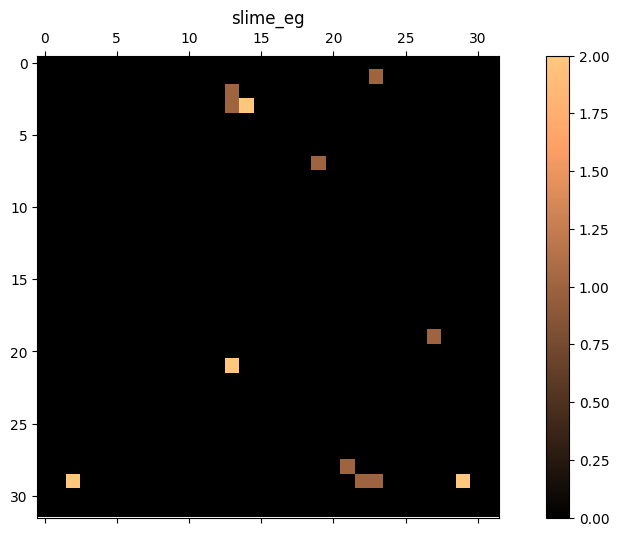

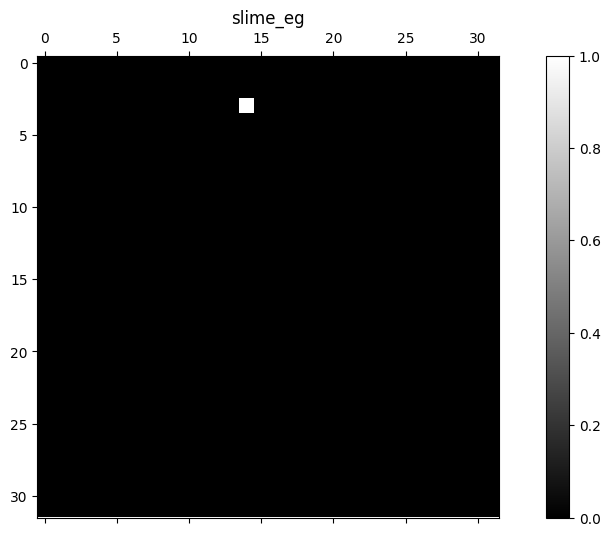

In [144]:
env = caenv.CAEnvironment("slime_eg")
env.gen_padded_food()
env.innoculate()
env.display()


In [145]:
ag = caag.CAAgent("Lame Agent")
def lame_rules(chunk, env):
    return [1] * env.n_channels

ag.set_rule_func(lame_rules)

rag = caag.CAAgent("Random Agent")
def rand_rules(chunk, env):
    return np.random.random(env.n_channels)
rag.set_rule_func(rand_rules)
print(ag.display())
print(rag.display())



CAAgent ID: Lame Agent
	KERNEL: von_n
	AGENT_TYPE: slime mold
CAAgent ID: Random Agent
	KERNEL: von_n
	AGENT_TYPE: slime mold


In [146]:
env.start_new_video(channels=(env.food_i, env.life_i), cmaps = (cm.copper,cm.gray))
for _ in range(30):
    # ag.apply_to_env(env, log=True, vid_speed=3)
    rag.apply_to_env(env, log=True, vid_speed=5)

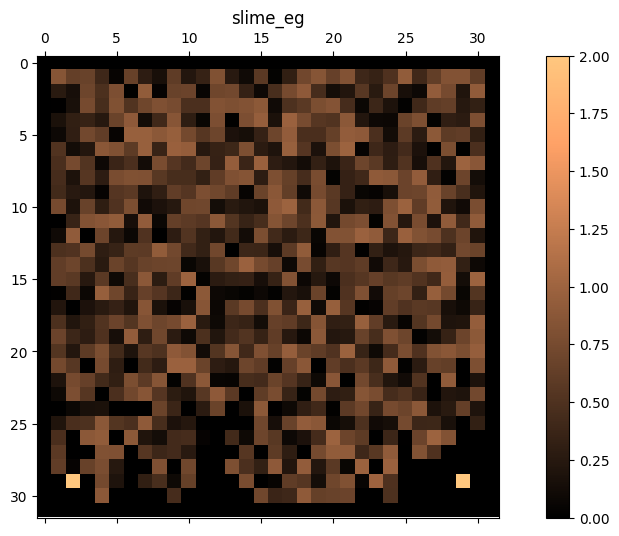

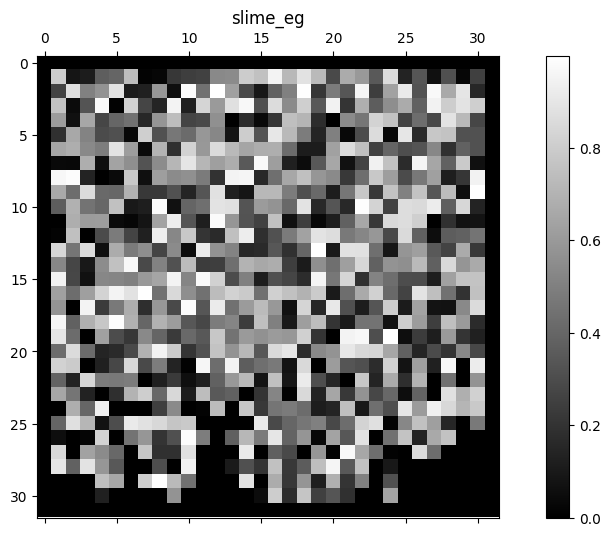

In [147]:
env.display()

In [148]:
Video(env.gen_video())

2022-11-09 09:00:51.995907: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3
	 1
	 2
2
	 2
	 3
	 1
	 4
1
	 1
	 2
	 3
5
	 1
	 2
4
	 3
	 2


/Users/aidanbarbieux/CSC/580-CSC/WIDDAK/nca/ca_environment.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # life_im = ax2.matshow(self.channels[channels[1]], cmap=cmaps[1])


	 1


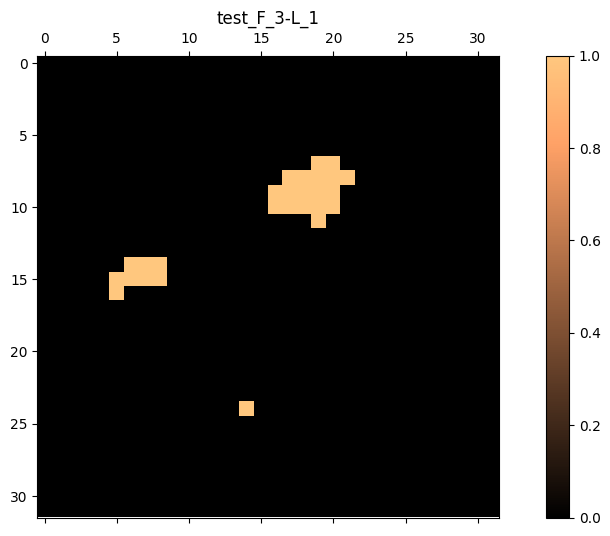

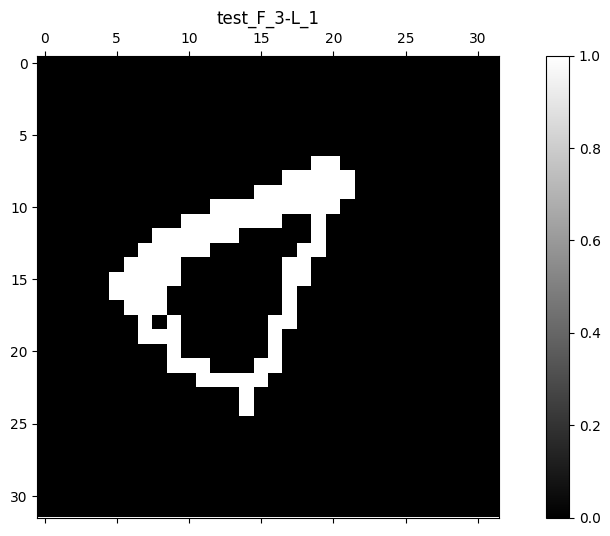

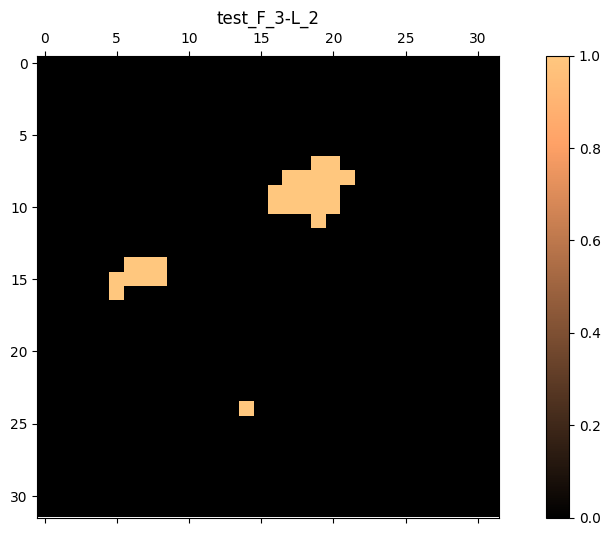

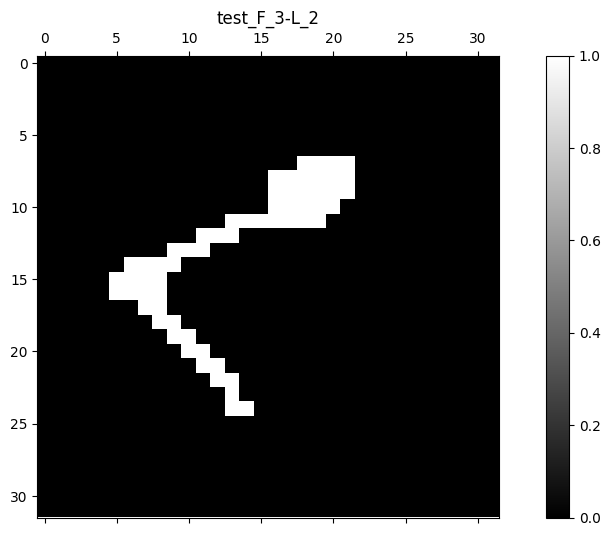

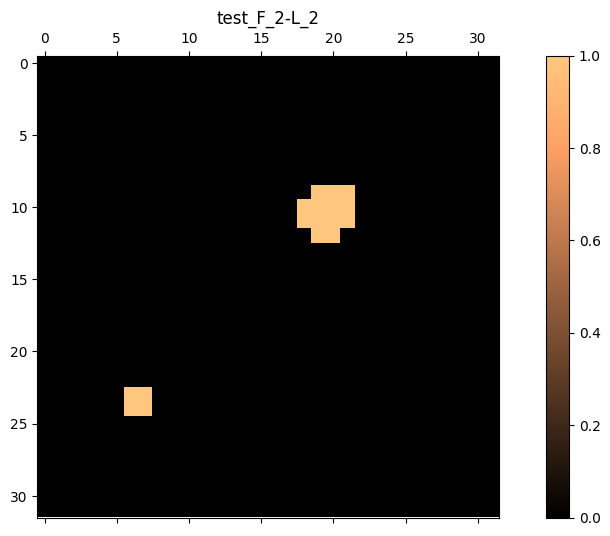

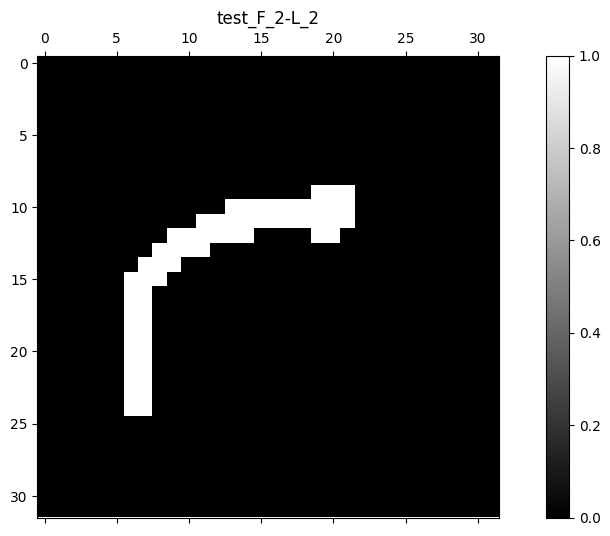

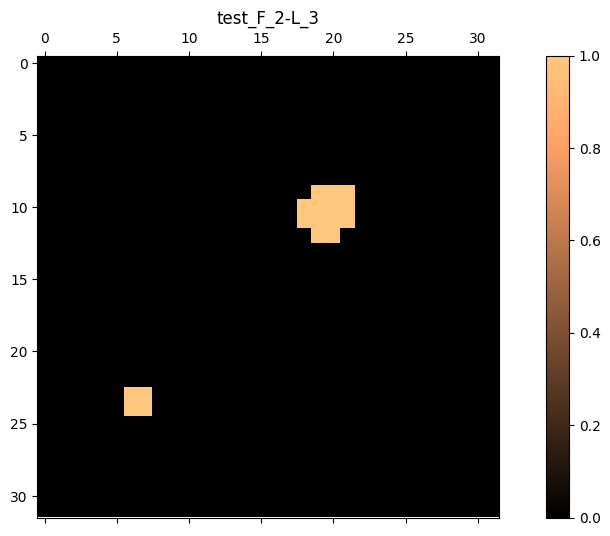

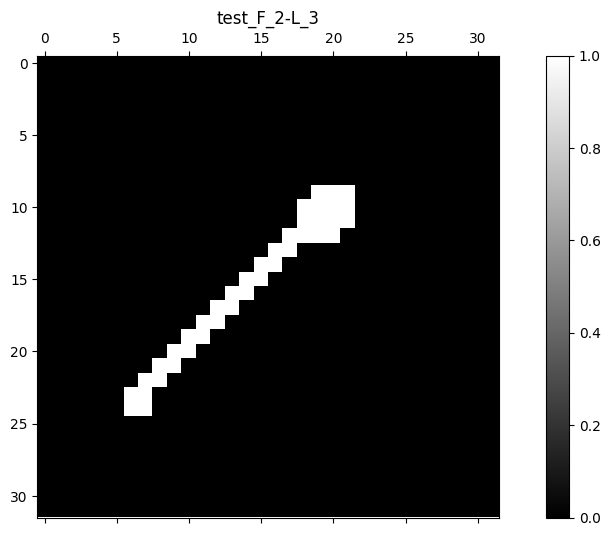

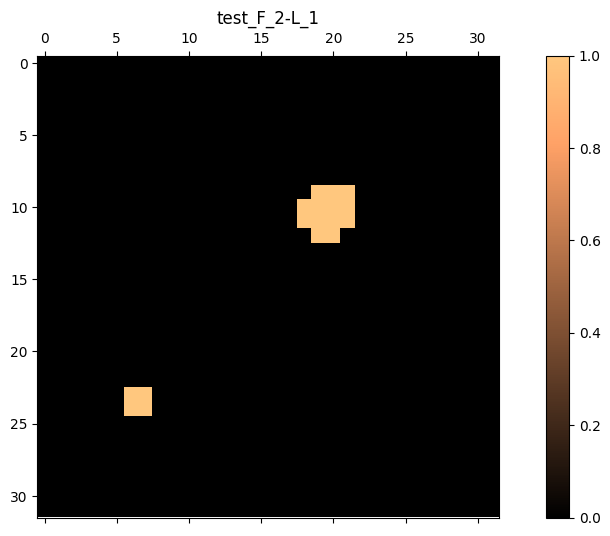

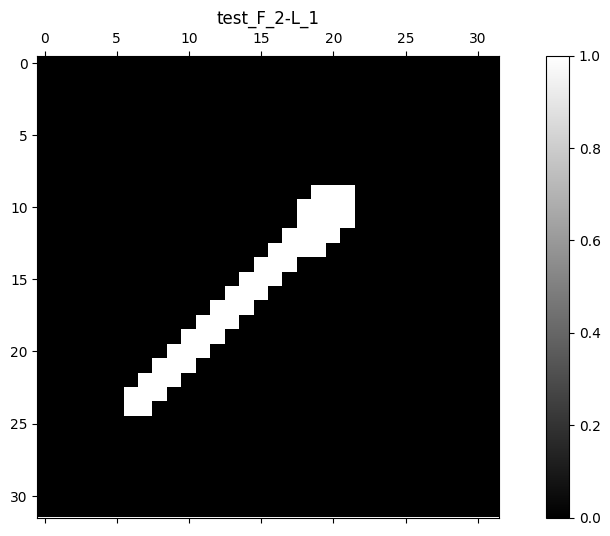

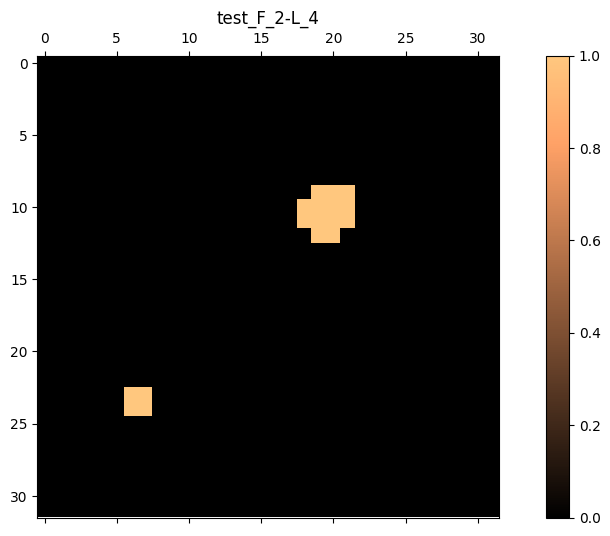

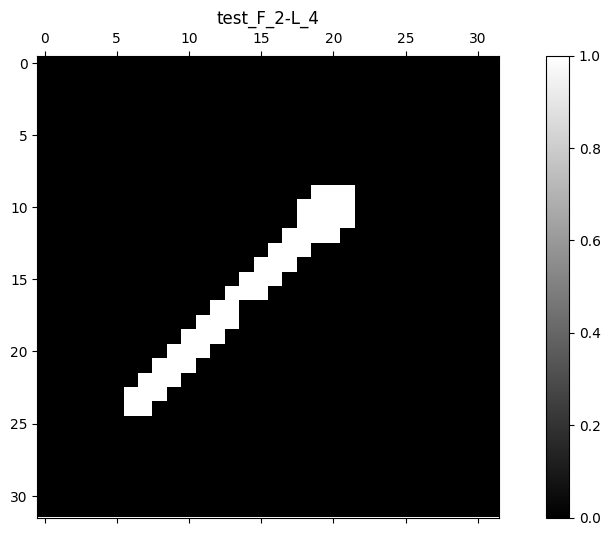

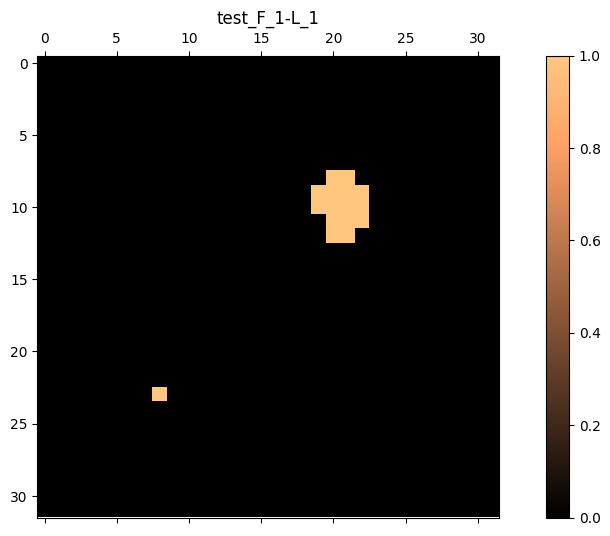

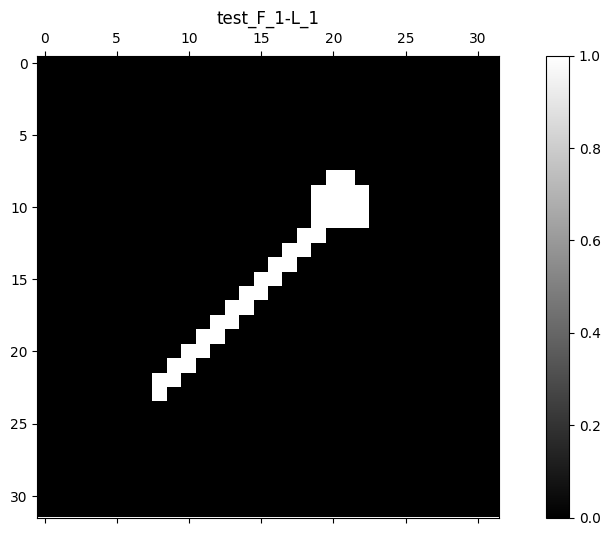

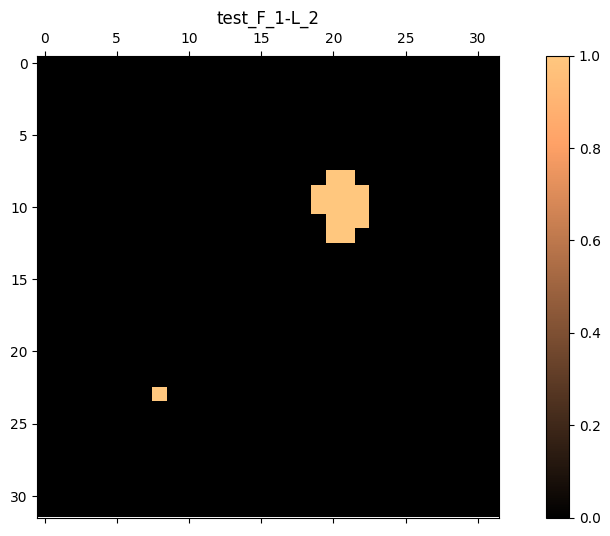

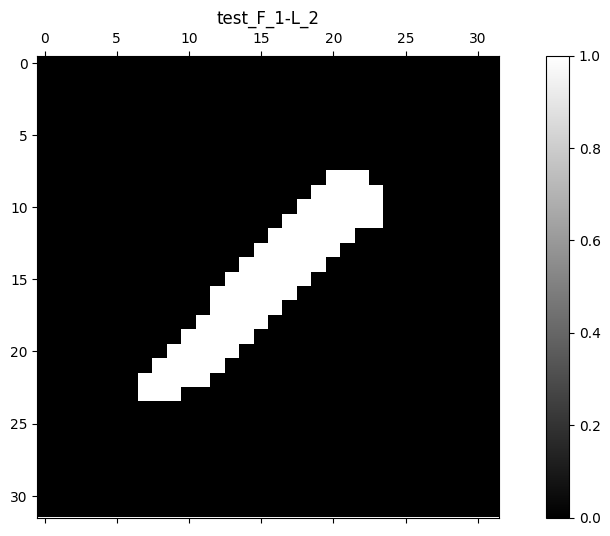

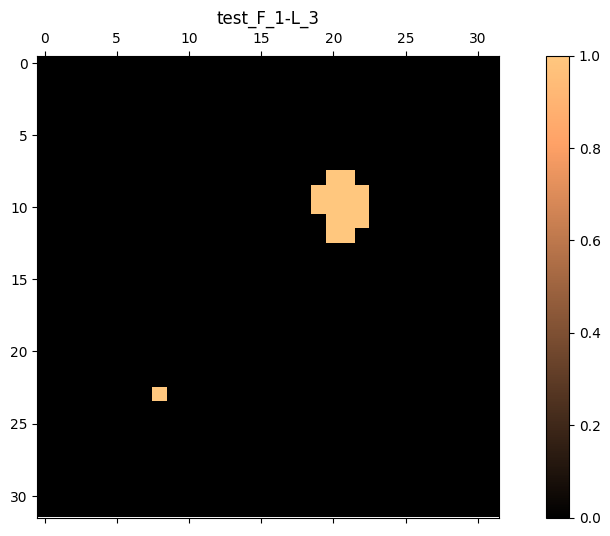

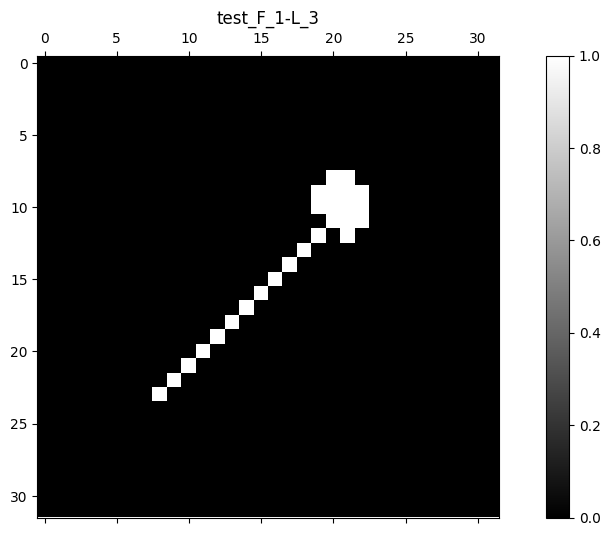

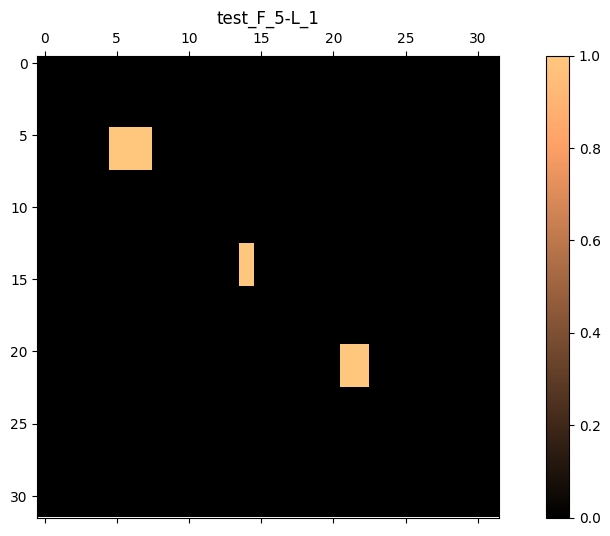

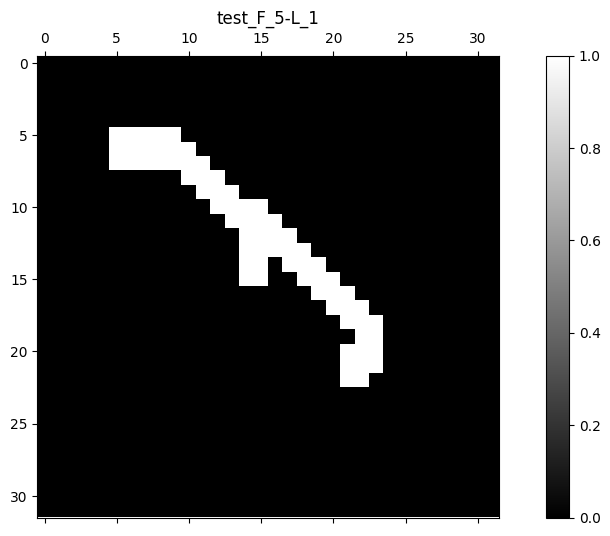

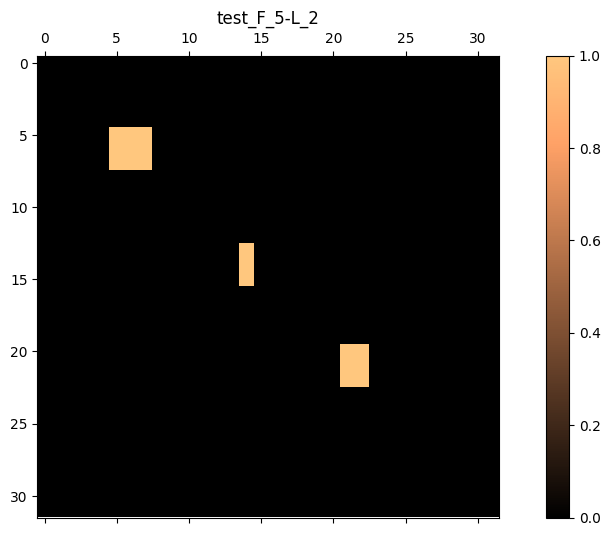

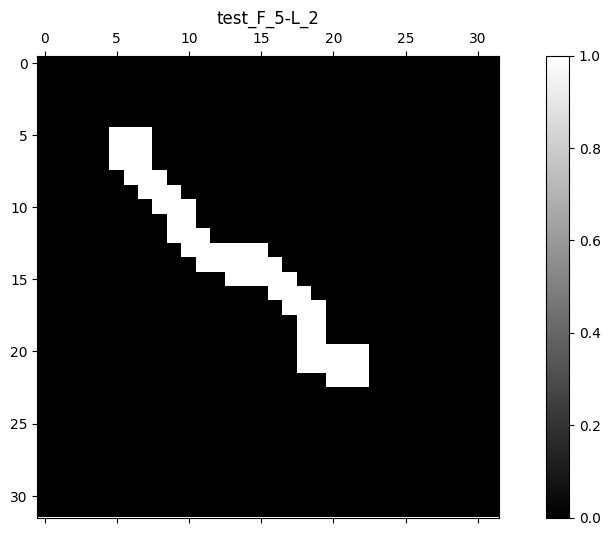

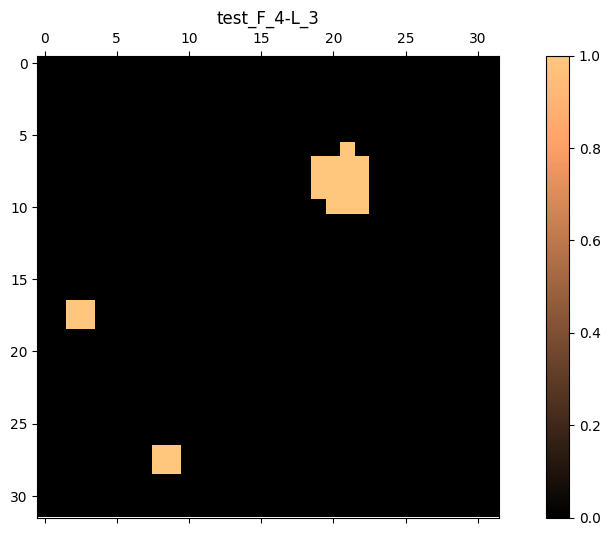

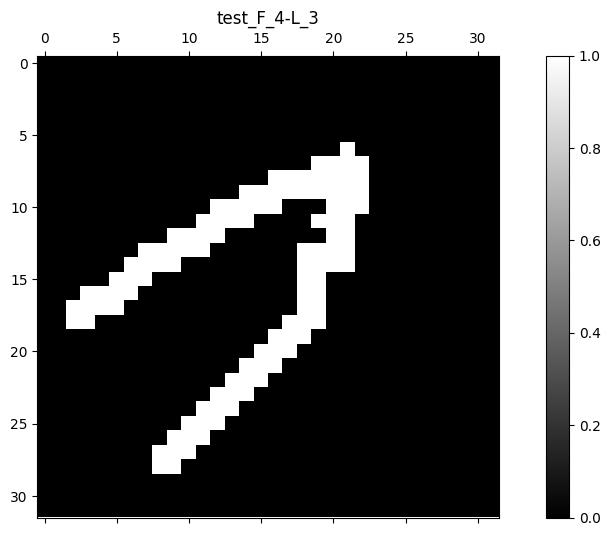

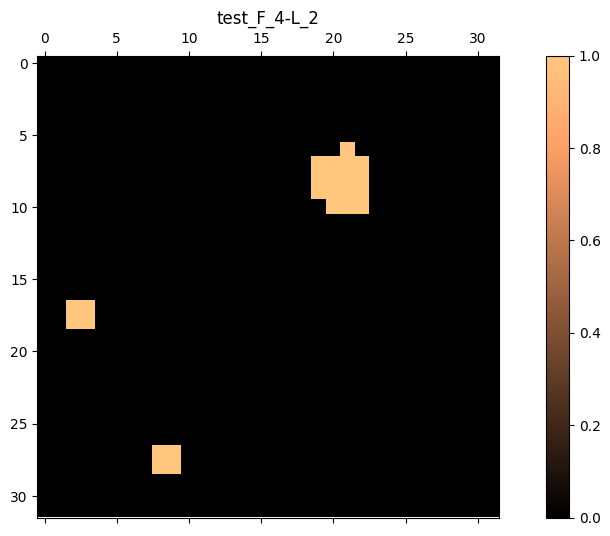

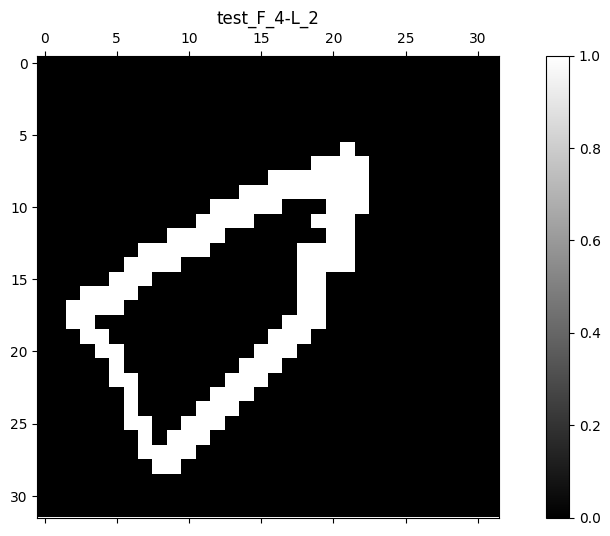

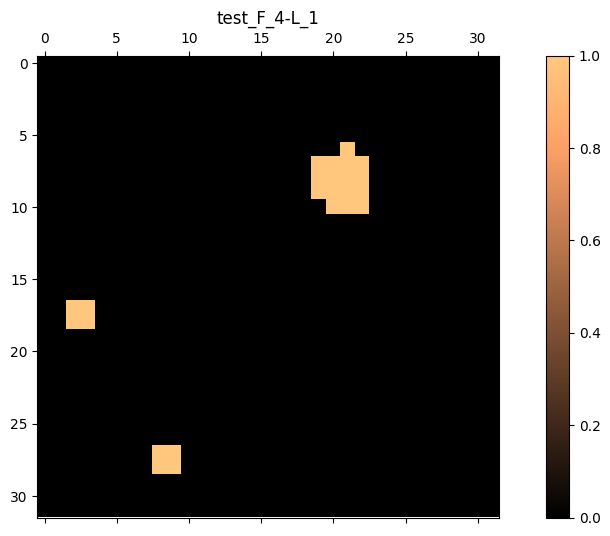

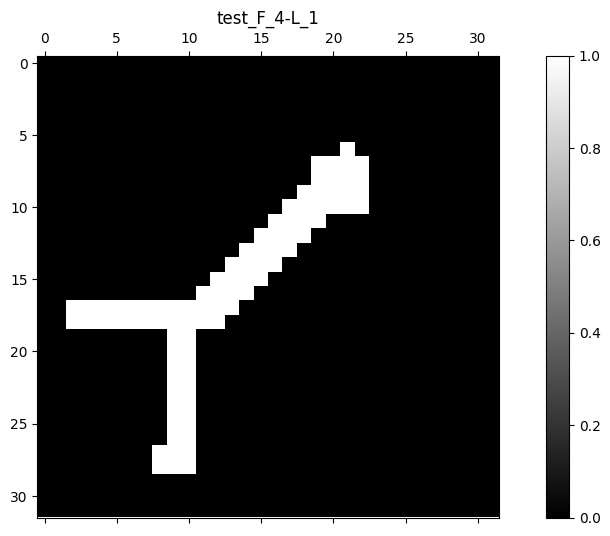

In [149]:
importlib.reload(eval_env)
tenvs = eval_env.load_tests()
for fkey in tenvs.keys():
    print(fkey)
    for ekey in tenvs[fkey].keys():
        print("\t",ekey)
        tenvs[fkey][ekey].display()

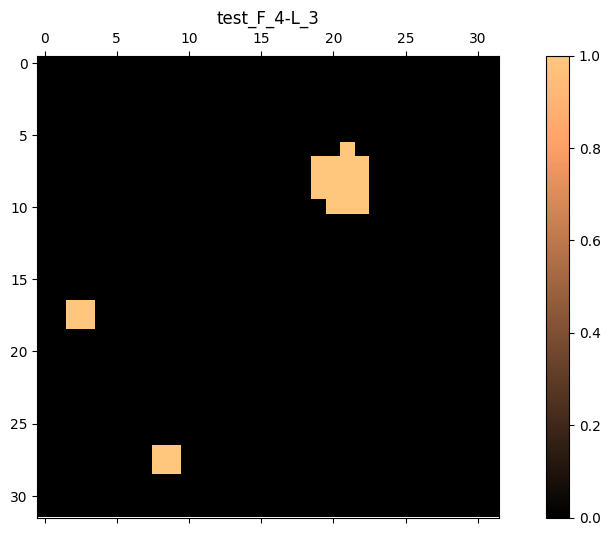

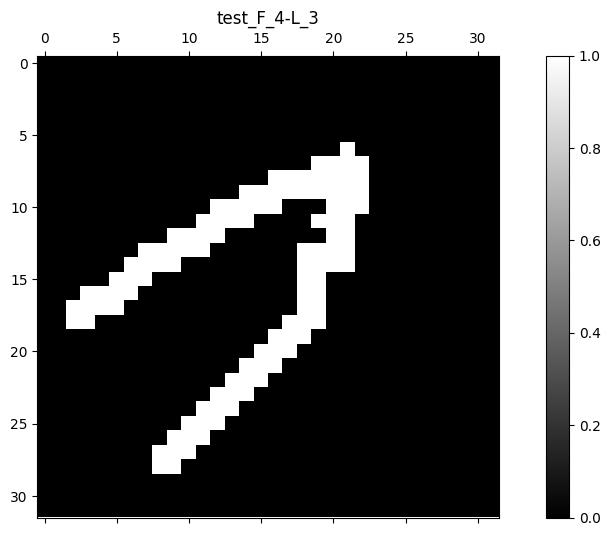

In [217]:
tenv = tenvs['4']['3']
tenv.display()

In [108]:
import sys
def rprint(text):
  sys.stdout.write("\r"+text)
  sys.stdout.flush()

In [205]:
import scipy.linalg as la
from scipy import sparse
import networkx as nx
from pyvis.network import Network


# Size is the length of one row in the grid
# Rook weight is the edge weight for top/down/left/right neighs
# Bishop weight is ^ for diag neighbors
def get_full_adj_grid(size, rook_weight=1., bishop_weight=0.5):
    col_rep = np.zeros(size)
    col_rep[1] = rook_weight
    offdi = sparse.csr_matrix(la.toeplitz(col_rep))

    I = np.eye(size)
    dg1 = np.roll(I, -1, axis=0) * bishop_weight/2
    dg1[:,0] = 0
    dg2 = np.roll(I, 1, axis=0) * bishop_weight/2
    dg2[:,-1] = 0
    I += dg1 + dg2
    I = sparse.csr_matrix(I)

    return sparse.kron(offdi,I) + sparse.kron(I,offdi)

def adj_matrix_from_grid(grid):
    mask = np.zeros((grid.size,grid.size))
    mask[grid.flatten().nonzero(),:] = grid.flatten()>0
    mask = sparse.csr_matrix(mask) 
    adj = get_full_adj_grid(grid.shape[0])
    return mask.multiply(adj)  

def drop_zero(M):
    # M: Sparse adjacency matrix
    return M[M.getnnz(1)>0][:,M.getnnz(0)>0] #GOOD

In [206]:
toy = np.array([[0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,1,0,0,0,0],
                [0,0,1,0,0,0,0,0],
                [0,0,0,1,1,0,0,0],
                [0,0,0,0,1,1,0,0],
                [0,0,0,0,0,0,0,0],])

toy_adj = drop_zero(adj_matrix_from_grid(toy))
net = nx.from_numpy_array(toy_adj)

netw = Network(notebook=True)
netw.from_nx(net)
netw.show("eg.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


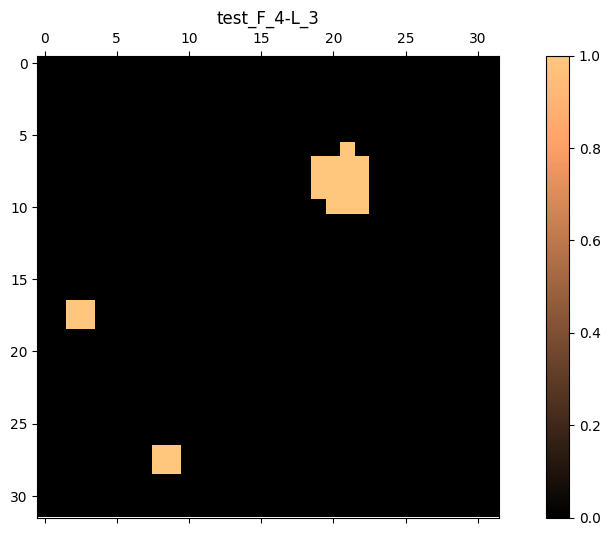

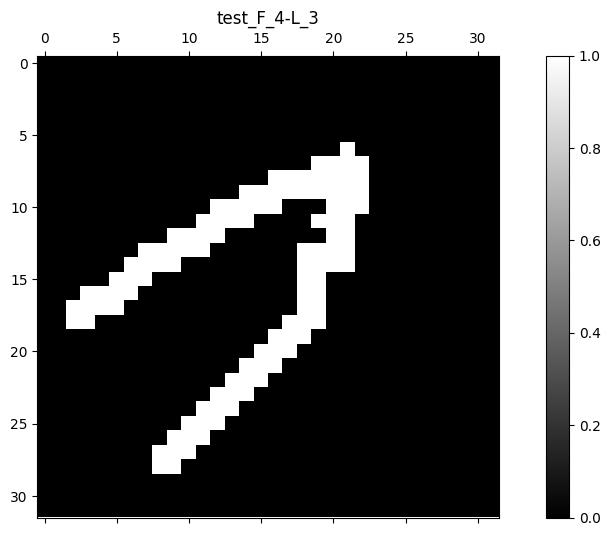

In [218]:
FOOD_RATE = 0.0
von_n = (np.array([-1,  0,  0, 1]),
         np.array([0, -1,  1,  0]))  # Von Neumann neighborhood indices
tenv.channels[tenv.hidden_i] *= 0

road_ch = (tenv.channels[tenv.life_i] * (tenv.channels[tenv.food_i] <= 0))

road_inds = road_ch.nonzero()
tenv.channels[tenv.hidden_i, road_inds[0],road_inds[1]] = 0     # Fill resevoirs

tenv.display(channels=[0,1])


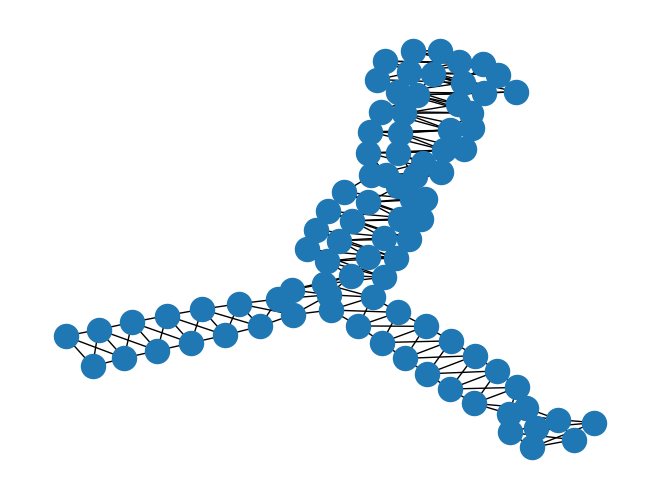

In [208]:
tenv_adj = drop_zero(adj_matrix_from_grid(tenv.channels[tenv.life_i]))
net = nx.from_scipy_sparse_array(tenv_adj)
nx.draw_kamada_kawai(net)

In [209]:
netw = Network(notebook=True)
netw.from_nx(net)
netw.show('eg.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


AssertionError: 

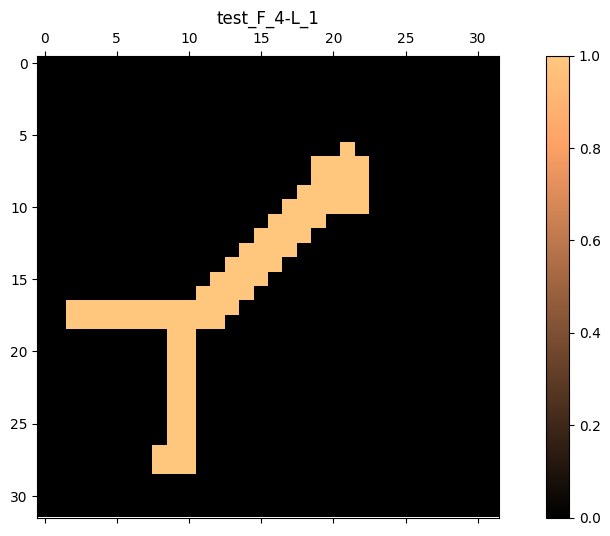

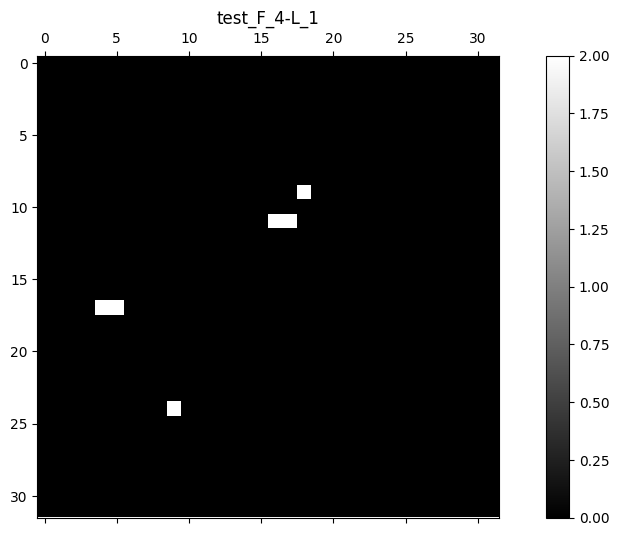

In [210]:
victims = np.random.randint(0,len(road_inds[0]),int(len(road_inds[0])/10.0))
tenv.channels[tenv.hidden_i, road_inds[0][victims], road_inds[1][victims]] = 2
tenv.display(channels=[1,2])

In [211]:
# test = np.array([[0,  0,  0],
#                  [10, 1,  10],
#                  [10, 10, 10]])
# kernel = np.array([[1,2,1],
#                    [0,0,0],
#                    [-1,-2,-1]])

# blurred = signal.fftconvolve(test, kernel, mode='same')
# fig, (ax_orig, ax_kernel, ax_blurred) = plt.subplots(3, 1, figsize=(6, 15))
# ax_orig.imshow(test, cmap='gray')
# ax_orig.set_title('Original')
# ax_orig.set_axis_off()
# ax_kernel.imshow(kernel, cmap='gray')
# ax_kernel.set_title('Gaussian kernel')
# ax_kernel.set_axis_off()
# ax_blurred.imshow(blurred, cmap='gray')
# ax_blurred.set_title('Blurred')
# ax_blurred.set_axis_off()
# fig.show()

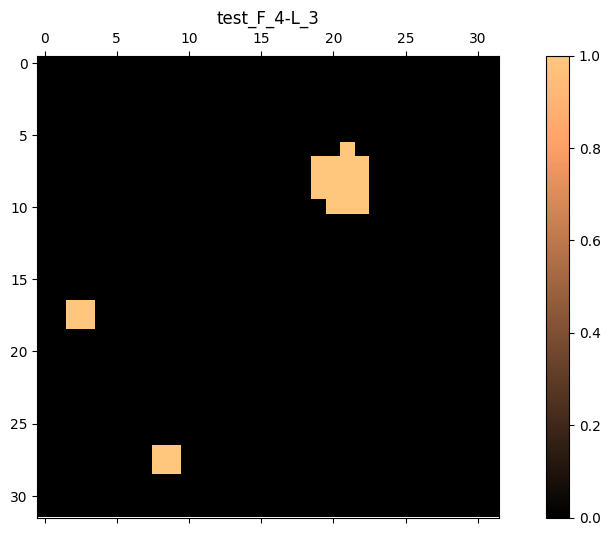

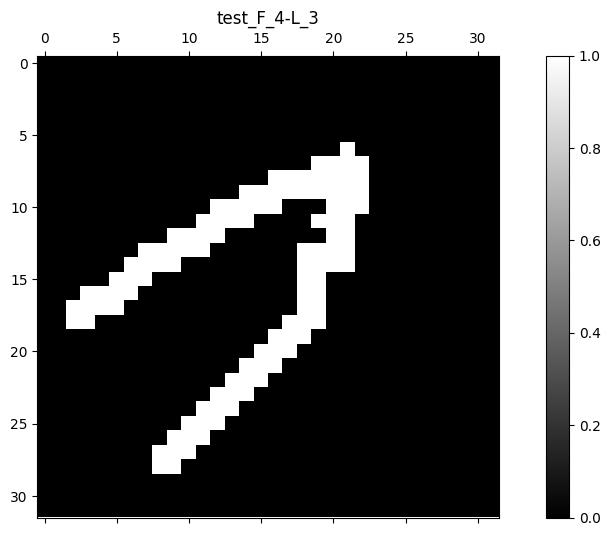

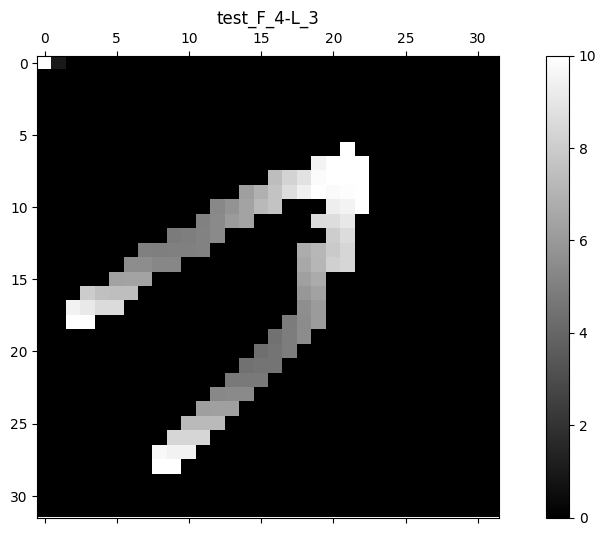

In [219]:
tenv.start_new_video(channels = [tenv.hidden_i], cmaps=[cm.hot])
start_sum = tenv.channels[tenv.hidden_i].sum()
stp=0
for _ in range(10): # 'Harm' 10 cells
    victim = np.random.randint(0,len(road_inds[0]))
    victim = (road_inds[0][victim], road_inds[1][victim])
    tenv.channels[tenv.hidden_i,victim[0],victim[1]] = -20 # Draw from one resevoir

    # tenv.display(channels=[tenv.hidden_i])
    # Propogate draw for 10 moves:
    for f in range(10):
        neg_cells = ((tenv.channels[tenv.hidden_i] < 10) * (tenv.channels[tenv.life_i] > 0)).nonzero() # If cell is alive and has has a depleted resevoir
        for i,j in zip(neg_cells[0],neg_cells[1]):
            for n in range(len(von_n[0])):
                if tenv.channels[tenv.life_i,von_n[0][n] + i, von_n[1][n] + j] > 0: # If neigh has life

                    tenv.channels[tenv.hidden_i, i, j] = min(tenv.channels[tenv.hidden_i, i, j]+ tenv.channels[tenv.food_i,i,j] * 0.25, 10)

                    val = tenv.channels[tenv.hidden_i, i, j]
                    nval = tenv.channels[tenv.hidden_i, von_n[0][n] + i, von_n[1][n] + j]

                    # rprint(str((nval - val)/2 - (val - nval)/2))
                    if val<nval:   
                        # tenv.channels[tenv.hidden_i, i, j] = nval
                        # tenv.channels[tenv.hidden_i, von_n[0][n] + i, von_n[1][n] + j] = val
                        tenv.channels[tenv.hidden_i, i, j] += (nval - val)/2
                        tenv.channels[tenv.hidden_i, von_n[0][n] + i, von_n[1][n] + j] += (val-nval)/2
                    stp+=1
                    if stp%50 == 0:
                        tenv.channels[tenv.hidden_i, 0,0] = 10
                        tenv.channels[tenv.hidden_i, 0,1] = 1

                        tenv.add_state_to_video()
            # print()
            # rprint(str(start_res - tenv.channels[tenv.hidden_i].sum()))
            
# for f in range(20):
#     neg_cells = ((tenv.channels[tenv.hidden_i] < 1) * (tenv.channels[tenv.life_i] > 0)).nonzero() # If cell is alive has has a depleted resevoir
#     for i,j in zip(neg_cells[0],neg_cells[1]):
#         for n in range(len(von_n[0])):
#             if tenv.channels[tenv.life_i,von_n[0][n] + i, von_n[1][n] + j] > 0: # If neigh has life
#                 # tenv.channels[tenv.hidden_i, i, j] = min(tenv.channels[tenv.hidden_i, i, j] + tenv.channels[tenv.food_i,i,j] * 0.25, 1)
#                 val = tenv.channels[tenv.hidden_i, i, j]
#                 nval = tenv.channels[tenv.hidden_i, von_n[0][n] + i, von_n[1][n] + j]

#                 tenv.channels[tenv.hidden_i, i, j] += (nval - val)/2
#                 tenv.channels[tenv.hidden_i, von_n[0][n] + i, von_n[1][n] + j] += (val-nval)/2
#                 stp+=1

#                 if f%50 == 0:
#                     tenv.channels[tenv.hidden_i, 0,0] = -5
#                     tenv.add_state_to_video()
#                     tenv.channels[tenv.hidden_i, 0, 0] = 0
tenv.display(channels=[0,1,2])

        # rprint(str(start_res - tenv.channels[tenv.hidden_i].sum()))

# tenv.display(channels=(tenv.food_i, tenv.life_i, tenv.hidden_i), cmaps=(cm.copper,cm.gray,cm.hot))
    # if f%1 == 0:
    #     tenv.channels[tenv.hidden_i, 0,0] = -5
    #     tenv.add_state_to_video()
    #     tenv.channels[tenv.hidden_i, 0,0] = 0

In [220]:
Video(tenv.gen_video())

ENVIRONMENT: test_F_1-L_2


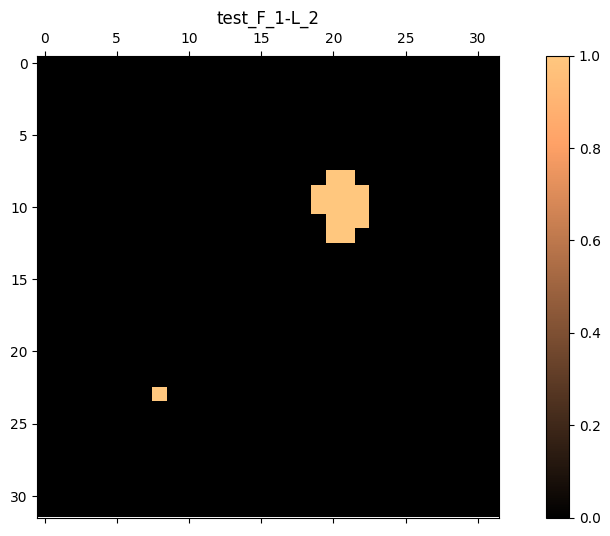

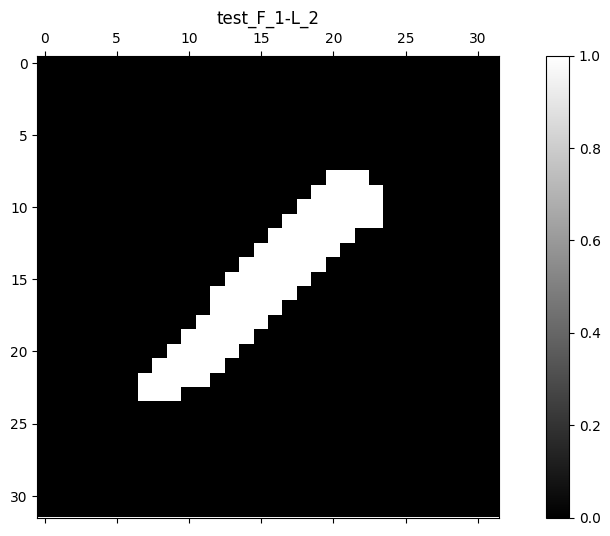

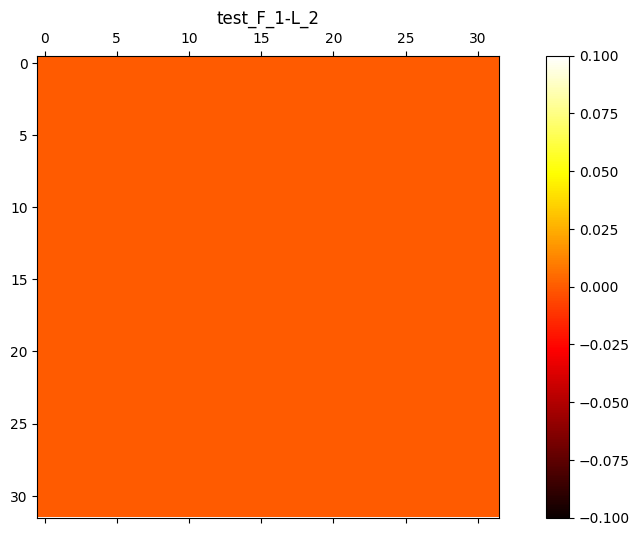

In [323]:
tenv.display(channels=(tenv.food_i, tenv.life_i, tenv.hidden_i), cmaps=(cm.copper,cm.gray,cm.hot))